![logo](../../LogoLine_horizon_C3S.png)

# Seasonal forecasts bias assessment for impact models

Production date: 08/03/2024

Produced by: Sandro Calmanti (ENEA)

## 🌍 Use case: Risk assessment in agriculture using seasonal forecasts as an input for climate impact models.

## ❓ Quality assessment questions
* **Do I have to correct systematic errors in temperature and precipitation before using seasonal forecasts as an input for my crop model?**
* **Can I assume that climate models always produce the same systematic error for seasonal forecasts over a certain area?** 

Seasonal forecasts can be used as an input to crop models for agricultural risk assessment [[1]](https://doi.org/10.1038/s41598-018-20628-2) [[2]](https://doi.org/10.1016/j.agrformet.2018.11.029) [[3]](https://doi.org/10.1016/j.cliser.2022.100324). However, the presence of systematic errors can undermine the performance of crop models in a number of ways, particularly when critical thresholds in the plant growth process are considered. Similar problems can arise in other sectoral applications, such as the management of renewable energy facilities [[4]](https://doi.org/10.1016/j.renene.2019.04.135), or the alerting of national health services for the occurrence of summer heat waves [[5]](https://doi.org/10.1007/s00382-021-05828-3). In addition to temperature and precipitation, the most commonly used climate variables for risk assessment in all sectoral applications, the notebook also considers wind speed and dew point temperature. While these variables are commonly used in agricultural applications to calculate potential evapotranspiration, the results of the assessment are also valuable for several other sectors.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Seasonal forecasts should be bias-corrected before being used as input to climate impact models. Depending on the impact model, it might be advisable to bias-correct the resulting impact indicator [[6]](https://doi.org/10.1175/JHM-D-19-0042.1)
* Model drifts and bias tend to be a complex function of both the start time of the forecast and of its valid time, with a slightly stronger dependence on the valid time for the case of temperature and precipitation. Therefore, the most appropriate approach to produce unbiased forecasts for use in impact models must be selected on a case-by-case basis.[[7]](https://doi.org/10.1007/s00382-019-04640-4) [[8]](https://doi.org/10.1007/s00382-017-3962-9)
* For the implementation of bias correction procedures, it is recommended that reference climatologies are computed for time scales no longer than one month, since the typical model bias changes on a monthly basis. Instead, the correction of model biases on a seasonal (i.e. three months) timescale may lead to a loss of quality.
* Similarly, the calculation of multi-model statistics requires a recalibration of the model output in order to align all models around the same climatological distribution. [[9]](https://doi.org/10.1007/s00382-020-05314-2)
```

```{figure} 8568344f-a005-4668-b14a-05d8ff7f3b96.png
---
height: 500px
---
The figure shows a sample  of the ECMWF monthly temperature bias for Western North America as a function of the starting month and of the valid month of the forecast. More details on how to interpret the results are available below in the notebook.
```

## 📋 Methodology

This notebook provides a comprehensive assessment of the systematic errors of the forecast systems by comparing the model predictions with the ERA5 reanalysis. The analysis is carried out for eight regions selected from those used in the IPCC-AR6 (see figure below), which capture the spatial scale of the main systematic errors already analysed in previous studies [[10]](https://doi.org/10.1007/s00382-019-04640-4)

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](seasonal_seasonal-monthly-single-levels_forecast-skill_q02:section-1):**
 * Import required packages
 * Define parameters describing regions, variables, and data
 * Plot the chosen regions
 * Define required functions
 * Show a sample global map of temperature biases

**[](seasonal_seasonal-monthly-single-levels_forecast-skill_q02:section-2):**
 * Retrieve monthly ERA5 data and compute the regional mean climatology, i.e. 12 values for each area
 * Compute area averages

**[](seasonal_seasonal-monthly-single-levels_forecast-skill_q02:section-3):**
 * Retrieve monthly seasonal forecast data from all available centres and for all starting dates, compute the monthly mean climatology (i.e. 6 values, since each forecast is valid for 6 months) and subtract the corresponding ERA5 climatology.
 * Compute area averages
 * Plot a sample map

**[](seasonal_seasonal-monthly-single-levels_forecast-skill_q02:section-4)**

**[](seasonal_seasonal-monthly-single-levels_forecast-skill_q02:section-5):** 
 * Plots are shown in a comprehensive set of panels that provide an overview of the multimodel performance 
 * The results are summarised and discussed

Note that crop models and other sectoral applications tend to use daily values rather than the monthly statistics considered in this notebook, and they focus on smaller areas compared to the regions considered below. However, the analysis of monthly data over the IPCC-AR6 regions provides a useful overview of the overall characteristics of the dataset.

Note that for ECCC, only one of the two systems has been analysed (system 3). This is different from the approach taken in the C3S charts, and CanSIPSv2.1, where both systems are combined (system 2 and system 3).

## 📈 Analysis and results

(seasonal_seasonal-monthly-single-levels_forecast-skill_q02:section-1)=
### 1. Choose the data to use and setup the code

#### Import required packages
We use the `regionmask package` to extract climatologies for a few selected regiones that have already e been adopted in several climate studies, including the analysis presented in the latest IPCC report.

A description of the regions adopted for climate assesements in the scientific literature is available [here](https://regionmask.readthedocs.io/en/stable/defined_scientific.html).

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import regionmask
import xarray as xr
import numpy as np
from c3s_eqc_automatic_quality_control import diagnostics, download, plot

plt.style.use("seaborn-v0_8-notebook")

#### Define parameters describing regions, variables, and data

In this notebook the analysis of the model bias is done for 5 variables from all 8 originating centres. The SREX regions selected for the analysis are:

- NEAF: Northern-East Africa
- ENA: Eastern North America
- MED: Southern Europe/Mediterranean
- NEB: North-eastern Brazil
- SAS: Southern Asia
- SEA: South-Eastern Asia
- WNA: Western North America
- NWS: Western Coast of South America

A `common_request` is defined in order to cover the entire global domain and the entire hindcast period from 1993 to 2016. Specific data requests are then defined for the reanalysis and for the seasonal forecasts, so that all available months and lead times are retrieved for the analysis.

In [2]:
# Time
year_start_hindcast = 1993
year_stop_hindcast = 2016

# Variable
variables = [
    "2m_temperature",
    "total_precipitation",
    "10m_wind_speed",
    "2m_dewpoint_temperature",
]

# Define centres with missing variables
missing_variables = {"eccc": ["2m_dewpoint_temperature"]}

# Centres
centres = {
    "cmcc": {"system": "35"},
    "dwd": {"system": "21"},
    "eccc": {"system": "3"},
    "ecmwf": {"system": "51"},
    "jma": {"system": "3"},
    "meteo_france": {"system": "8"},
    "ncep": {"system": "2"},
    "ukmo": {"system": "601"},
}
assert all("system" in v for v in centres.values())
assert set(centres) <= {
    "cmcc",
    "dwd",
    "eccc",
    "ecmwf",
    "jma",
    "meteo_france",
    "ncep",
    "ukmo",
}

# Regions
defined_regions_module_name = "ar6.land"
regions = [
    "NWS",
    "ENA",
    "MED",
    "NEAF",
    "NES",
    "SAS",
    "SEA",
    "WNA",
]

# Plotting settings
plot_kwargs = {
    "total_precipitation": {"cmap": "BrBG"},
}


# Define data requests
chunks = {"year": 1, "variable": 1}
common_request = {
    "format": "grib",
    "area": [89.5, -179.5, -89.5, 179.5],
    "year": [str(year) for year in range(year_start_hindcast, year_stop_hindcast + 1)],
}

collection_id_reanalysis = "reanalysis-era5-single-levels-monthly-means"
request_reanalysis = common_request | {
    "product_type": "monthly_averaged_reanalysis",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "time": "00:00",
}

collection_id_seasonal = "seasonal-monthly-single-levels"
request_seasonal = common_request | {
    "product_type": "monthly_mean",
    "leadtime_month": list(map(str, range(1, 7))),
    "month": [f"{month:02d}" for month in range(1, 13)],
    "grid": "1/1",
}

#### Plot the chosen regions
For the bias analysis we use 8 out of the 45 regions defined in the `regionmask` package in order to assess the systematic errors of the modelling systems under different climatic regimes (tropical, extratropical, continental, maritime) with a number of cases maneageable within the notebook.

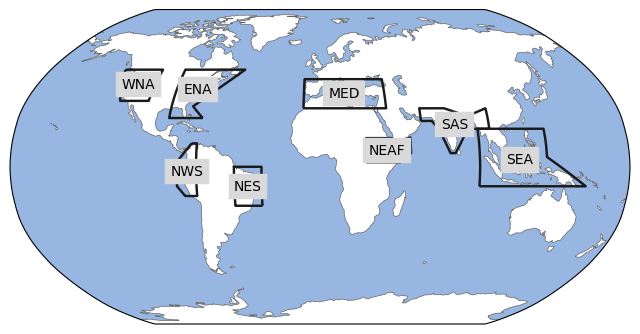

In [3]:
def get_defined_regions(defined_regions_module_name):
    defined_regions = regionmask.defined_regions
    for module in defined_regions_module_name.split("."):
        defined_regions = getattr(defined_regions, module)
    return defined_regions


defined_regions = get_defined_regions(defined_regions_module_name)
assert set(regions) <= set(defined_regions.abbrevs)

ax = defined_regions[regions].plot(
    projection=ccrs.Robinson(),
    label="abbrev",
    add_ocean=True,
)
ax.set_global()

#### Define the required functions

- The `regionalised_spatial_weighted_mean` function extracts the regional means over the selected domains. It uses spatial weighting to account for the latitudinal dependence of the grid size in the lon-lat grids used for the reanalysis and for the forecast models. The bias is then calculated later in the notebook by simply subtracting the regional means.

- The `postprocess_dataarray` function performs two important postprocessings operations required to align the arrays containing the reanalsysis and the forecast data. 

    - The time dimensions are renamed to allow the broadcasting of the dimension `valid_time`, which is used to compute the bias, independently of the corresponding `lead_times` in the forecast. 

    - Furthermore, the cumulative variables have to be rescaled in order to make ERA5 data and seasonal forecast data comparable on a monthly timescale. A [conversion table](https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790)  for accumulated variables is available in the [Copernicus Knowledge Base](https://confluence.ecmwf.int/pages/viewpage.action?pageId=55116796) repository.

- The function `get_seasonal_maps` is used to derive a sample bias map to illustrate how the analysis is performed.

- The `monthly_mean` function will be used to derive the monthly values at the appropriate `monthly_mean` before calculating the bias.

In [4]:
def regionalised_spatial_weighted_mean(
    ds, region, defined_regions_module_name, weights, mean_dims=None
):
    defined_regions = get_defined_regions(defined_regions_module_name)
    mask = defined_regions.mask(ds)
    index = defined_regions.map_keys(region)
    ds = ds.where((mask == index).compute(), drop=True)
    ds = diagnostics.spatial_weighted_mean(ds, weights=weights)
    if mean_dims:
        return ds.mean(mean_dims, keep_attrs=True)
    return ds


def postprocess_dataarray(da):
    time_dims = {dim for dim in da.dims if "time" in dim}
    if time_dims:
        if len(time_dims) == 1:
            (valid_time,) = time_dims
        else:
            starting_time = "forecast_reference_time"
            (valid_time,) = time_dims - {starting_time}
            da = da.rename({starting_time: "starting_time"})
        da = da.rename({valid_time: "valid_time"})

    if "leadtime" in da.coords:
        da = da.drop_vars("leadtime")

    # Convert units
    name = da.name
    units = da.attrs["units"]
    m_to_mm = 1.0e3
    day_to_s = 60 * 60 * 24
    if name == "total_precipitation" and units != "mm/month":
        match units:
            case "m":
                factor = m_to_mm
            case "m s**-1":
                factor = m_to_mm * day_to_s
            case _:
                raise ValueError(f"{name=} {units=}")
        if "valid_time" in da.coords:
            factor *= da["valid_time"].dt.days_in_month
            units = "mm/month"
        else:
            units = "mm/day"
    elif name == "surface_solar_radiation_downwards" and units != "W m**-2":
        match units:
            case "J m**-2":
                factor = 1 / day_to_s
                units = "W m**-2"
            case _:
                raise ValueError(f"{name=} {units=}")
    else:
        return da

    with xr.set_options(keep_attrs=True):
        da *= factor
    da.attrs["units"] = units
    return da


def get_seasonal_map(ds, starting_month, valid_month, grid_out, **kwargs):
    starting_time = "forecast_reference_time"
    (valid_dim,) = {dim for dim in ds.dims if "time" in dim} - {starting_time}
    (year,) = set(ds[starting_time].dt.year.values)

    for dim, prefix in {starting_time: "starting", valid_dim: "valid"}.items():
        ds = (
            ds.groupby(f"{dim}.month")
            .mean(keep_attrs=True)
            .rename(month=f"{prefix}_month")
        )
    ds = ds.sel(starting_month=starting_month, valid_month=valid_month)
    ds = ds.mean("realization", keep_attrs=True)

    ds = diagnostics.regrid(ds, grid_out, **kwargs)
    return ds.expand_dims(year=[year])

def monthly_mean(ds):
    for dim in ds.dims:
        if "time" in dim:
            ds = (
                ds.groupby(f"{dim}.month")
                .mean(keep_attrs=True)
                .rename(month=dim.replace("time", "month"))
            )
    return ds

(seasonal_seasonal-monthly-single-levels_forecast-skill_q02:section-2)=
### 2. ERA5 data retrieval and area average

The `regionalised_spatial_weighted_mean` is applied for all regions and all variables selected for download. All time series of the regionalised means are collected in the same xarray `ds_reanalysis`.

In [ ]:
# Get the reanalysis data
datasets = []
for region in regions:
    dataarrays = []
    for variable in variables:
        print(f"{region=} {variable=}")
        ds = download.download_and_transform(
            collection_id_reanalysis,
            request_reanalysis | {"variable": variable},
            chunks=chunks,
            transform_func=regionalised_spatial_weighted_mean,
            transform_func_kwargs={
                "region": region,
                "defined_regions_module_name": defined_regions_module_name,
                "weights": True,
            },
        )
        (da,) = ds.data_vars.values()
        dataarrays.append(postprocess_dataarray(da.rename(variable)))
    ds = xr.merge(dataarrays)
    datasets.append(ds.expand_dims(region=[region]).compute())
ds_reanalysis = xr.concat(datasets, "region")
del datasets

(seasonal_seasonal-monthly-single-levels_forecast-skill_q02:section-3)=
### 3. Seasonal hindcast data retrieval and area average

The `regionalised_spatial_weighted_mean` is applied for all centres, regions and all variables selected for download. Missing variables are handled, so the download and transform process is not interrupted. All time series of the regionalised means are collected in the same xarray `ds_seasonal`.

In [ ]:
# Get the seasonal forecast data
datasets = []
for centre, request_kwargs in centres.items():
    for region in regions:
        dataarrays = []
        for variable in variables:
            print(f"{centre=} {region=} {variable=}")
            if variable in missing_variables.get(centre, []):
                print("SKIP")
                continue

            ds = download.download_and_transform(
                collection_id_seasonal,
                request_seasonal
                | {"originating_centre": centre, "variable": variable}
                | request_kwargs,
                chunks=chunks,
                transform_func=regionalised_spatial_weighted_mean,
                transform_func_kwargs={
                    "region": region,
                    "defined_regions_module_name": defined_regions_module_name,
                    "weights": True,
                    "mean_dims": ("realization",),
                },
                backend_kwargs={
                    "time_dims": (
                        "verifying_time",
                        (
                            "indexing_time"
                            if centre in ["ukmo", "jma", "ncep"]
                            else "time"
                        ),
                    )
                },
            )
            (da,) = ds.data_vars.values()
            dataarrays.append(postprocess_dataarray(da.rename(variable)))
        ds = xr.merge(dataarrays)
        datasets.append(ds.expand_dims(centre=[centre], region=[region]).compute())
ds_seasonal = xr.merge(datasets)
del datasets

#### Show a sample global map of temperature biases

To reduce computation, this notebook simplifies the bias analysis by focusing on mean values of surface variables across the chosen regions. The goal is to offer a broad overview of the bias evolution over lead times. Thus, it is crucial that the selected regions exhibit sufficient homogeneity to minimize the compensation effects from systematic errors of varying sign.

This section of the notebook offers a simple tool for exploring sample bias maps and confirming that bias sign remain relatively constant within selected regions. Additionally, it serves as an insight on the behavior of individual models summarized in the comprehensive tables provided later in the notebook.

In [ ]:
# Set parameters
starting_month = 1
valid_month = 1
variable = "2m_temperature"
centre = "cmcc"
assert all(month in range(1, 13) for month in (starting_month, valid_month))
assert variable in variables
assert centre in centres

# Get reanalysis map
ds = download.download_and_transform(
    collection_id_reanalysis,
    request_reanalysis | {"variable": variable},
    chunks=chunks,
    transform_chunks=False,
    transform_func=diagnostics.monthly_weighted_mean,
)
ds = ds.rename(month="valid_month").sel(valid_month=valid_month)
grid_out = ds[["latitude", "longitude"]]
(da,) = ds.data_vars.values()
da_reanalysis = postprocess_dataarray(da.rename(variable))

# Get seasonal map
ds = download.download_and_transform(
    collection_id_seasonal,
    request_seasonal
    | {"originating_centre": centre, "variable": variable}
    | centres[centre],
    chunks=chunks,
    transform_func=get_seasonal_map,
    transform_func_kwargs={
        "starting_month": starting_month,
        "valid_month": valid_month,
        "grid_out": grid_out,
        "method": "bilinear",
    },
    backend_kwargs={
        "time_dims": (
            "verifying_time",
            ("indexing_time" if centre in ["ukmo", "jma", "ncep"] else "time"),
        )
    },
)
ds = ds.mean("year", keep_attrs=True)
(da,) = ds.data_vars.values()
da_seasonal = postprocess_dataarray(da.rename(variable))

# Compute bias
with xr.set_options(keep_attrs=True):
    bias = da_seasonal - da_reanalysis
bias.attrs["long_name"] = "Bias of " + bias.attrs["long_name"]

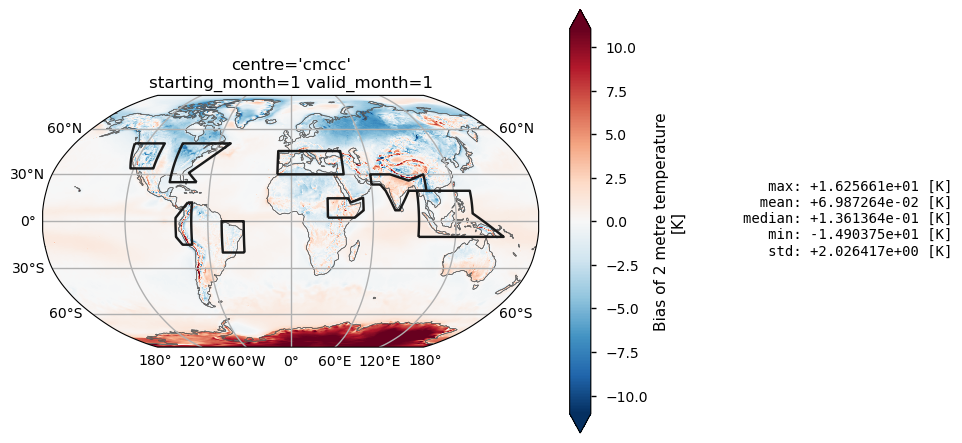

In [8]:
# Plot
plot.projected_map(
    bias, projection=ccrs.Robinson(), **plot_kwargs.get(variable, {}) | {"robust": True}
)
defined_regions[regions].plot(add_label=False)
_ = plt.title(f"{centre=}\n{starting_month=} {valid_month=}")

(seasonal_seasonal-monthly-single-levels_forecast-skill_q02:section-4)=
### 4. Compute the hindcast bias

The the seasonal hindcast data are arranged in a four-dimensional array `ds_seasonal[i,j,n,k]`, where:
> * `i` is the reference start month of the forecast (from January to December)
> * `j` is the valid time of the forecast (from January to December)
> * `n` is the originating centre of the forecast (currently a maximum of 8)
> * `k` is the region (currently 8)

Correspondingly, ERA5 data are arranged in a three-dimensional array `ds_seasonal[j,n,k]`, where:
> * `j` is the valid time of the forecast (from January to December)
> * `n` is the originating centre of the forecast (currently a maximum of 8)
> * `k` is the region (currently 8)

With such a shaping and setup of the datasets `ds_seasonal` and `ds_reanalysis` the computation of the bias is straightforward.

In [8]:
ds_reanalysis = monthly_mean(ds_reanalysis)
ds_seasonal = monthly_mean(ds_seasonal)

with xr.set_options(keep_attrs=True):
    bias = ds_seasonal - ds_reanalysis
for da in bias.data_vars.values():
    da.attrs["long_name"] = "Bias of \n " + da.attrs["long_name"]
# Avoid ticks interpolation
bias = bias.assign_coords(
    {name: coord.astype(str) for name, coord in bias.coords.items()}
)

(seasonal_seasonal-monthly-single-levels_forecast-skill_q02:section-5)=
### 5. Plot and describe results

#### How to read the results
The following tables summarise the monthly bias for chosen C3S seasonal systems (labelled by producing centre) and selected areas. 

In each panel, the horizontal axis represents the validity period of the forecast, while the vertical axis shows the corresponding start dates. Thus, each horizontal strip of coloured tiles shows the evolution of the mean temperature bias over the six-month period of validity of each forecast.

Reading each panel from bottom to top, the strips of coloured tiles are progressively shifted by one month, corresponding to the same shift in the starting date of the forecast. The horizontal axis is periodic: forecasts starting after August have their last months on the left side of the panel.

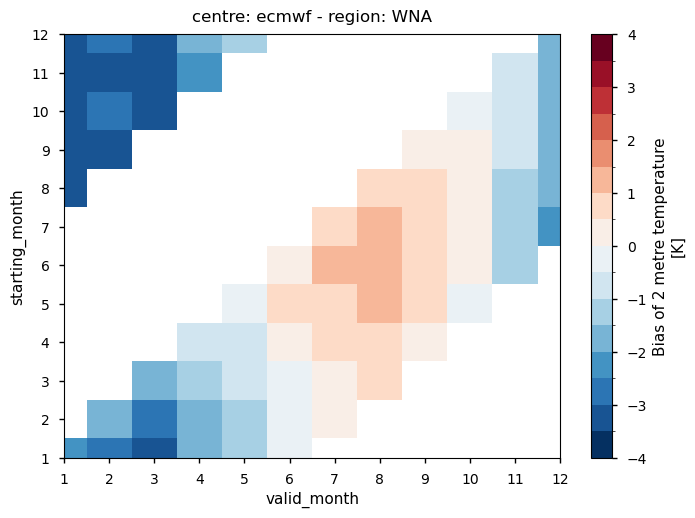

In [9]:
centre = "ecmwf"
region = "WNA"
ax = bias["2m_temperature"].sel(centre=centre,region=region).plot(x="valid_month",cmap="RdBu_r", levels = np.arange(-4, 4.5, .5))
_ = plt.title(f"centre: {centre} - region: {region}", y=1.01)

#### Discussion

The tables below summarise the monthly bias for all originating centres (columns) and for all selected areas (rows). Note that only one system (system 3) is shown from the ECCC contributions.

**Temperature** - All seasonal forecast models produce a significant temperature bias over most of the regions selected for analysis.  Two centres, DWD and METEOFRANCE, produce a forecast with a predominant warm bias over most regions and in all seasons.  The temperature bias is a function of both the start time and the valid time of the forecast, with a slightly stronger dependence on the valid time. Therefore, the bias does not increase with the lead time of the forecast. Instead, it tends to be a characteristic aspect of each model over the specific region and time of year. The seasonal cycle of the bias is particularly evident over western North America.

**Precipitation** - As in the case of temperature, the bias in precipitation tends to be more dependent on the validity period of the forecasts. The regions with the largest systematic bias are northeastern Brazil and southern Asia, where all models tend to overestimate the amplitude of the seasonal cycle.

**Wind speed** - Unlike temperature and precipitation, the bias of wind speed does not show a significant seasonal cycle over most of the selected regions. The only exceptions are northeastern Brazil and southern Asia, where some models (e.g. ECCC and NCEP) show a positive bias during the months of June to September.

**Dew point temperature** - As in the case of wind speed, the dew point temperature bias tends to have a weaker seasonal cycle than temperature and precipitation. However, some regions (southern Asia and western North America) show a slightly stronger seasonal dependence of the bias. NOTE: Dew point temperature is not available for ECCC.

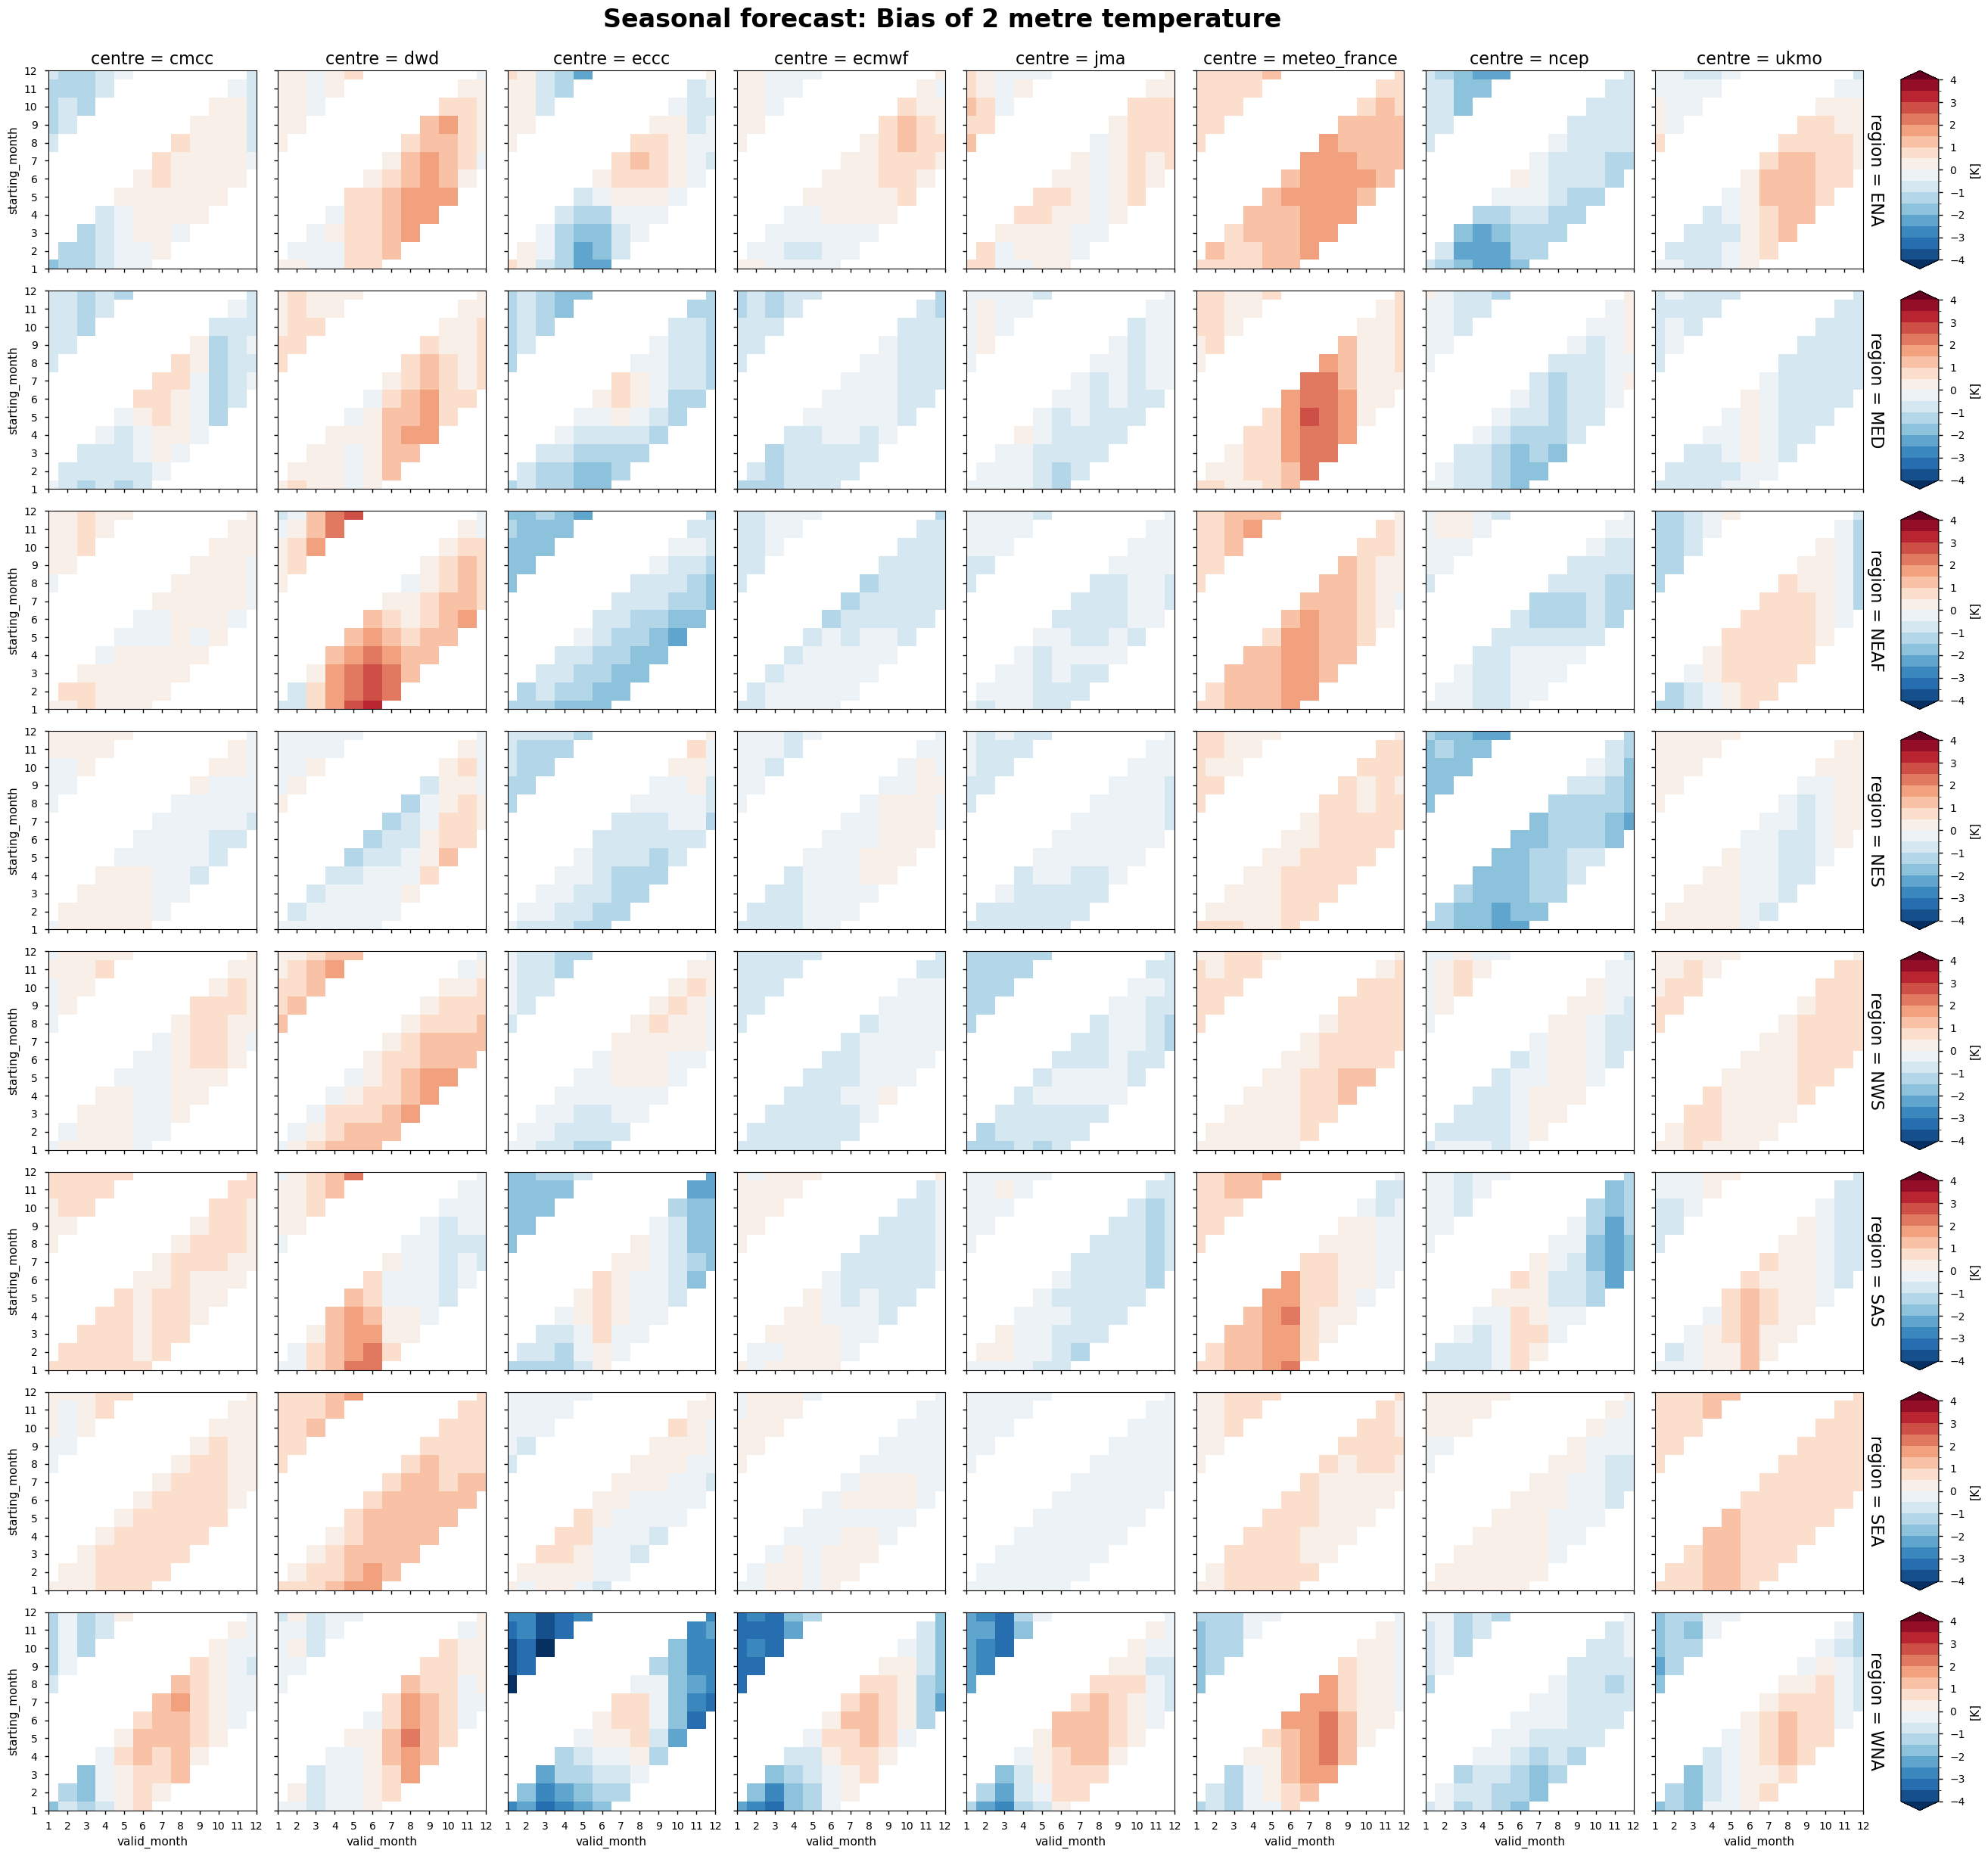

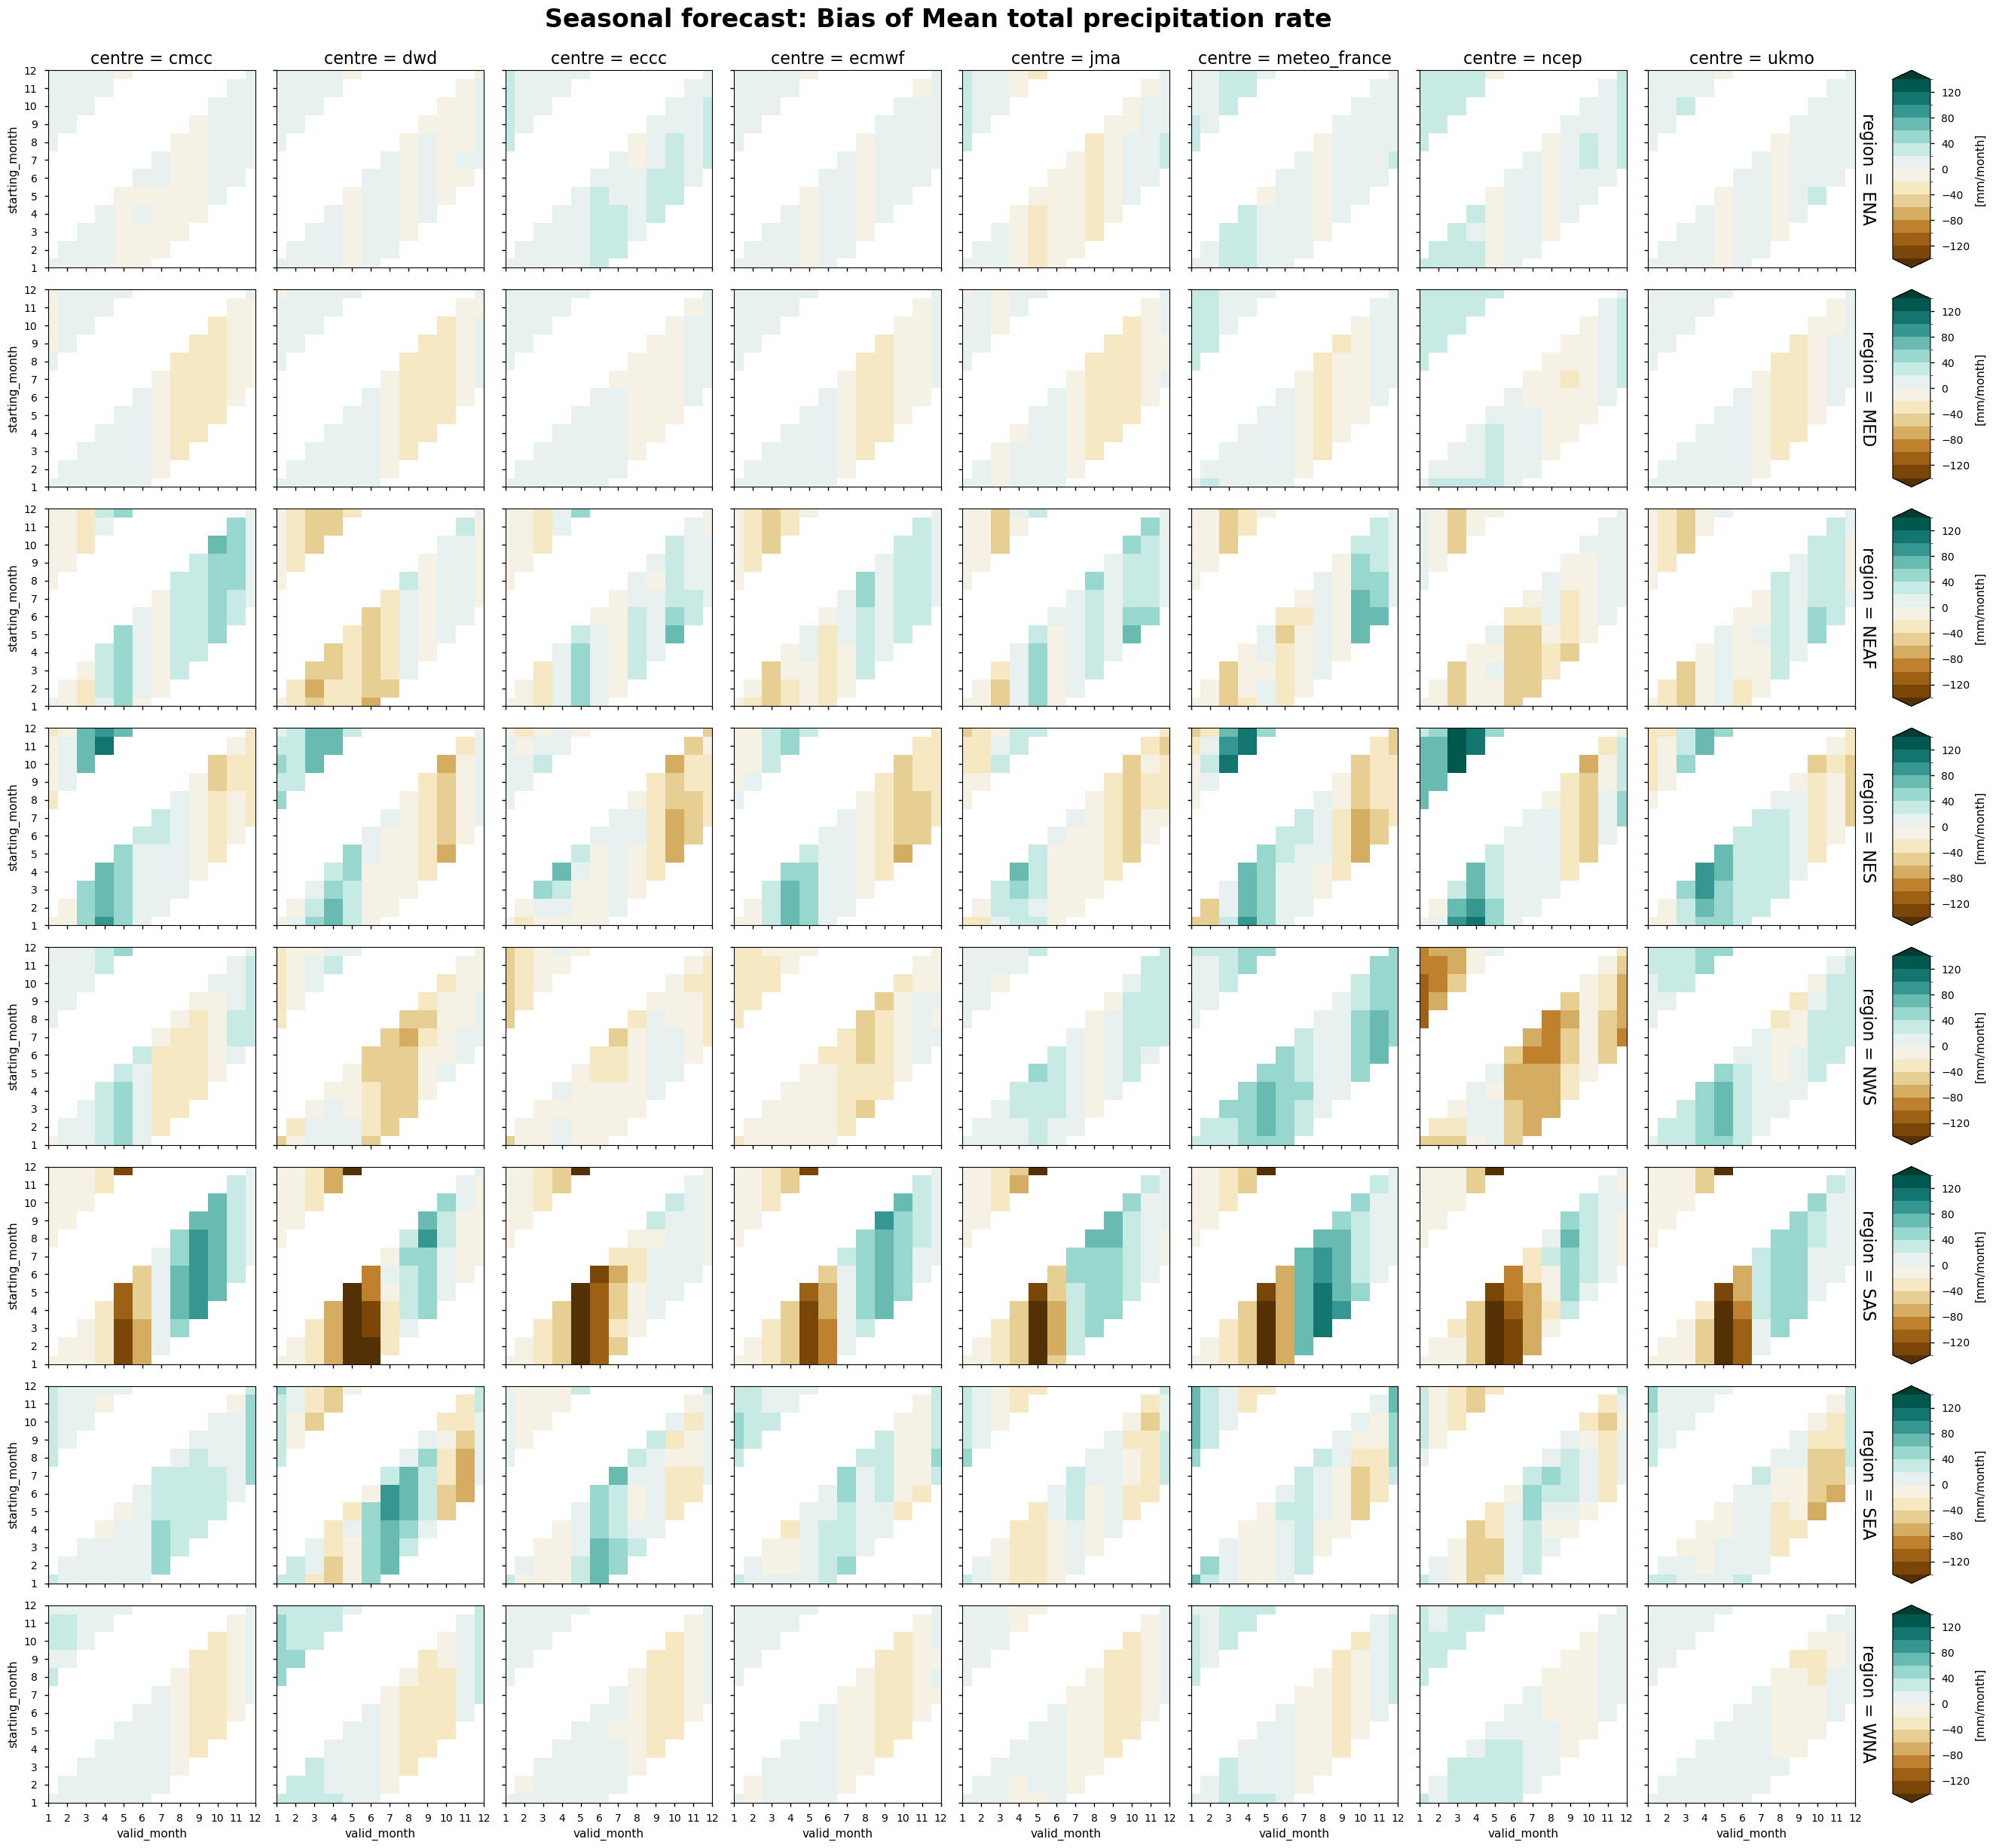

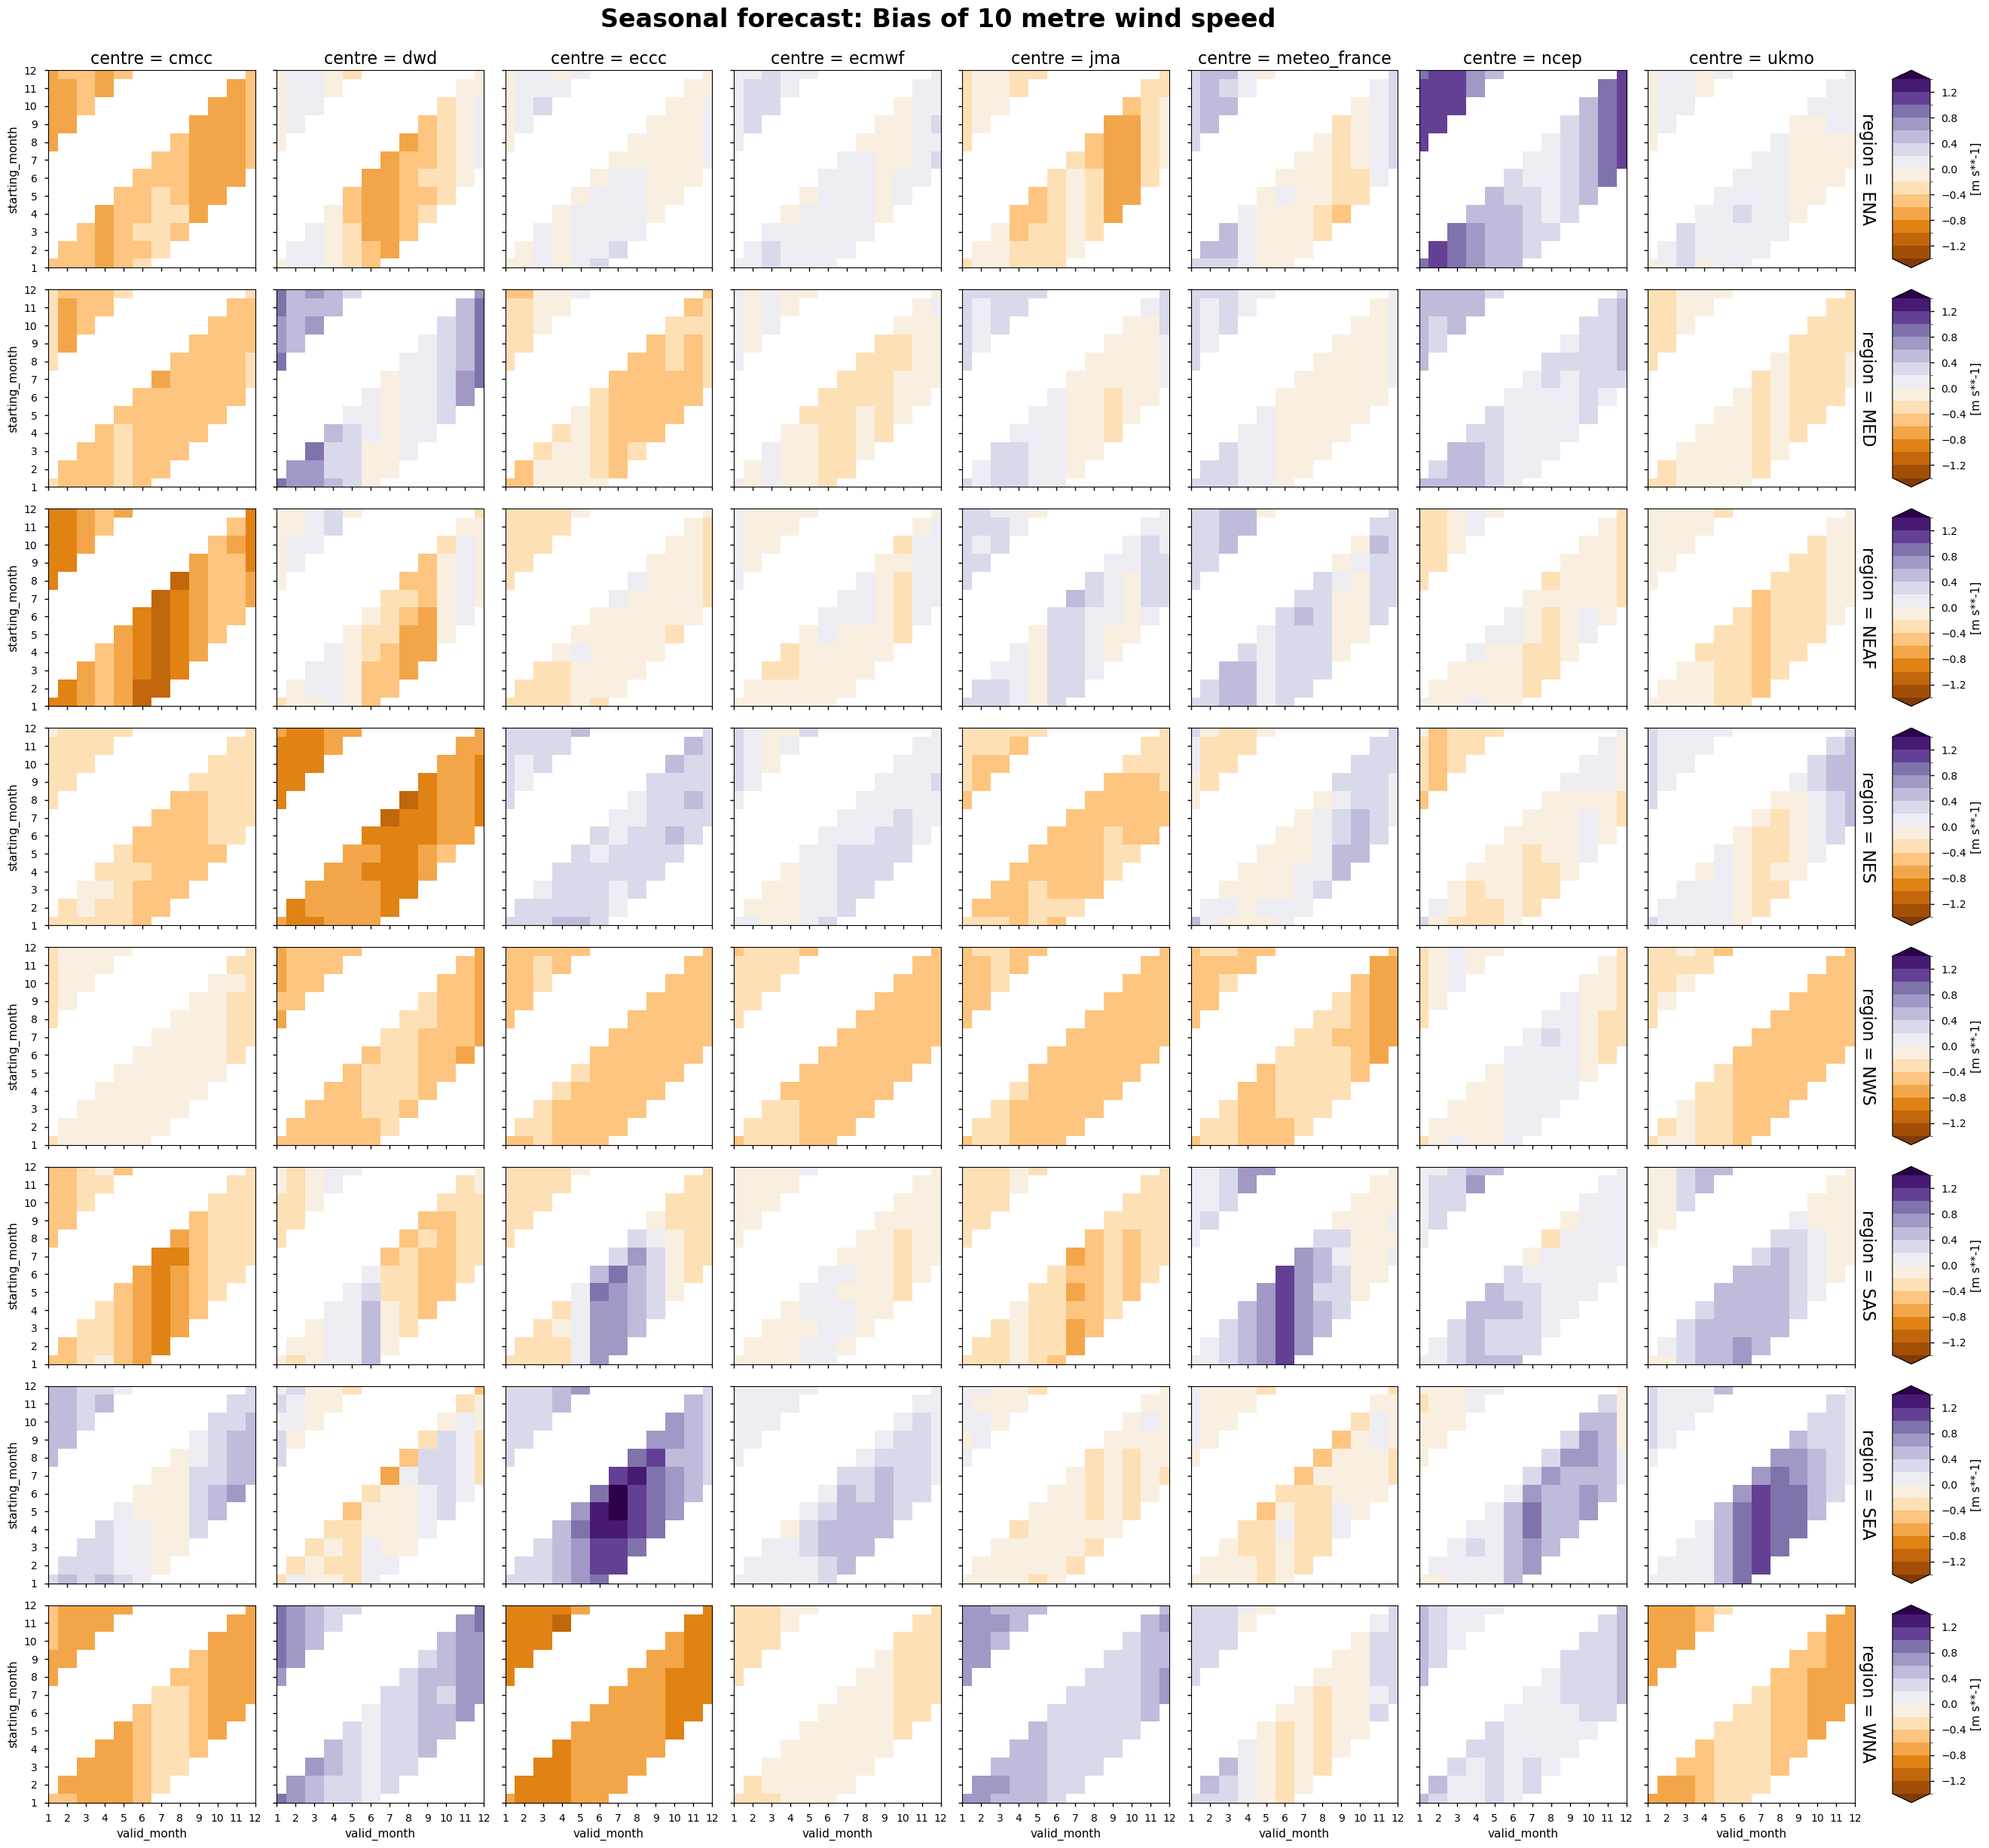

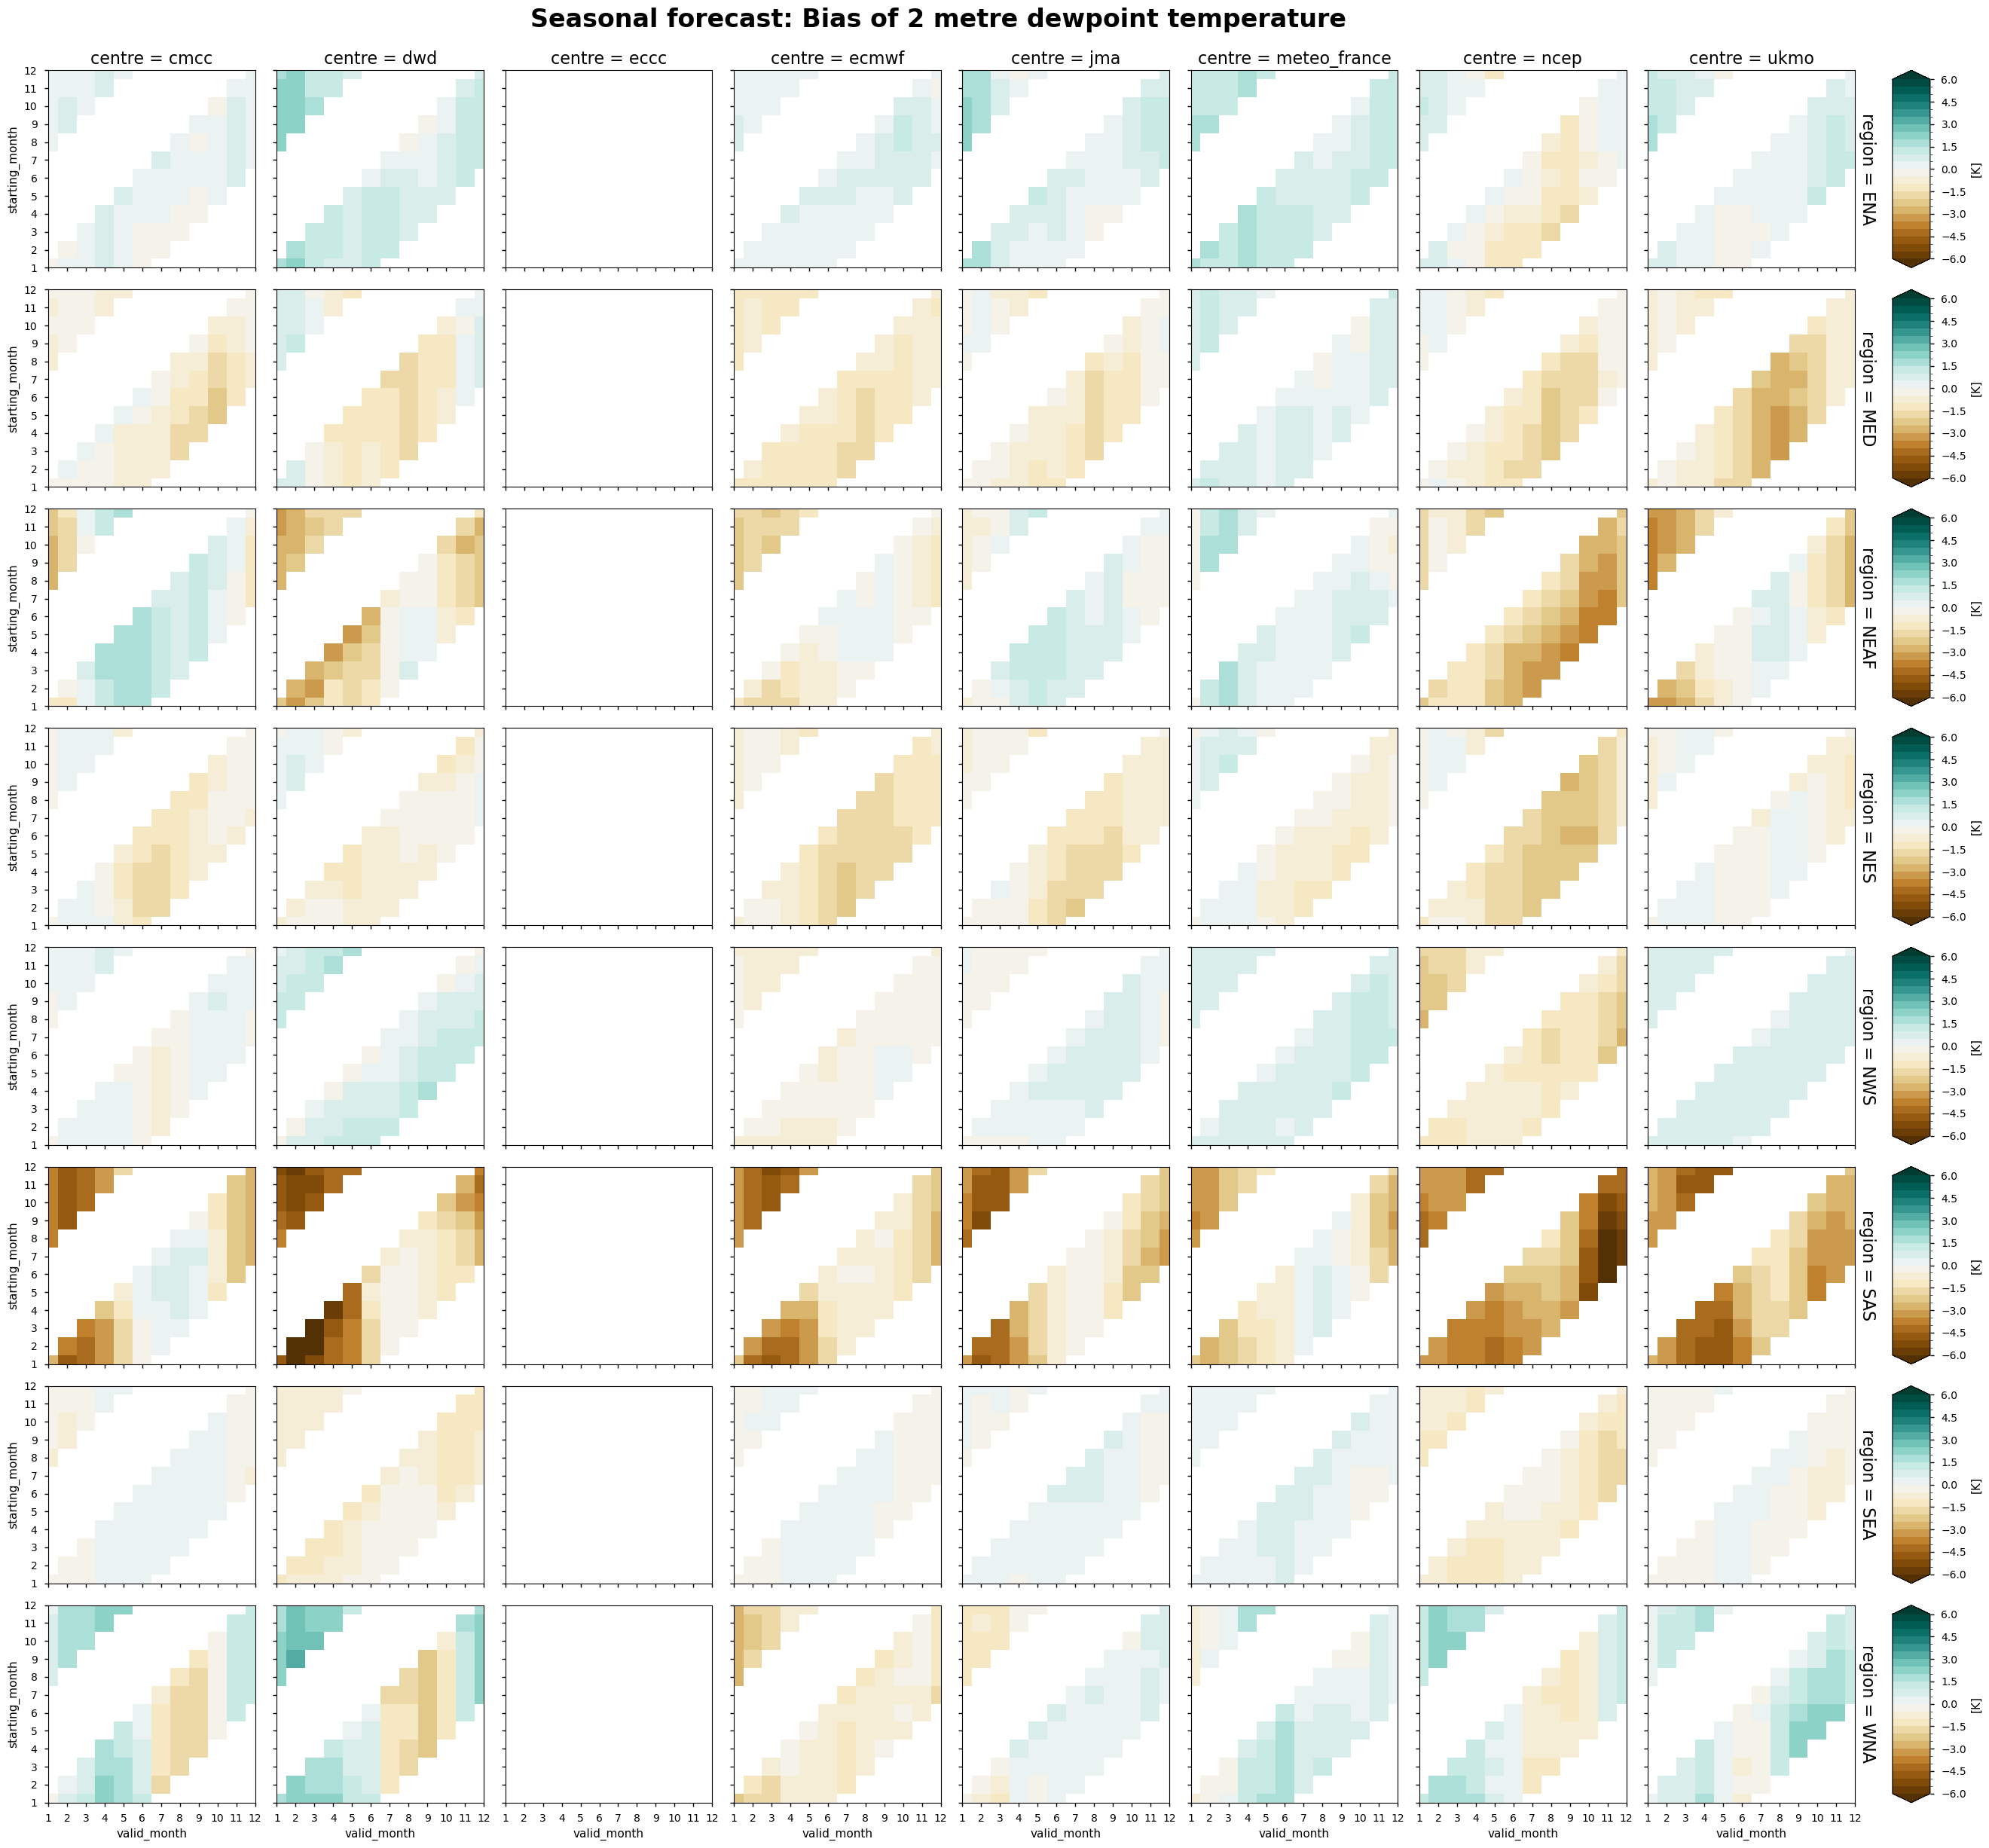

In [16]:
plot_kwargs = {
    "2m_temperature": {"cmap": "RdBu_r", "levels": np.arange(-4, 4.5, .5), "extend": "both"},
    "total_precipitation": {"cmap": "BrBG", "levels": np.arange(-140, 160, 20), "extend": "both"},
    "10m_wind_speed": {"cmap": "PuOr", "levels": np.arange(-1.4, 1.5, .2), "extend": "both"},
    "2m_dewpoint_temperature": {"cmap": "BrBG", "levels": np.arange(-6, 6.5, .5), "extend": "both"},
}

cbar_width = cbar_pad = 0.02
for varname, da in bias.data_vars.items():
    facet = da.plot(
        col="centre", row="region", x="valid_month", add_colorbar=False, **plot_kwargs.get(varname, {})
    )
    facet.fig.suptitle(f"Seasonal forecast: {da.attrs['long_name']}", y=1.02, fontsize=24, fontweight='bold')
    facet.set_titles(fontsize=16)
    
    # Create a colorbar for each row
    for ax in facet.axs[:, -1]:
        pos = ax.get_position()
        cax = facet.fig.add_axes([pos.x1 + cbar_pad, pos.y0, cbar_width, pos.height])
        facet.fig.colorbar(
            ax.collections[0],
            cax=cax,
            label=f"[{da.attrs['units']}]"
        )

    plt.show()

## ℹ️ If you want to know more

### Key resources

Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entries for the data used were:
* Seasonal forecast monthly statistics on single levels: https://cds.climate.copernicus.eu/datasets/seasonal-monthly-single-levels?tab=overview
* ERA5 monthly averaged data on single levels from 1940 to present: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=overview


Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.1038/s41598-018-20628-2) Rodriguez, D., De Voil, P., Hudson, D., Brown, J. N., Hayman, P., Marrou, H., & Meinke, H. (2018). Predicting optimum crop designs using crop models and seasonal climate forecasts. Scientific reports, 8(1), 2231.

[[2]](https://doi.org/10.1016/j.agrformet.2018.11.029) Jha, P. K., Athanasiadis, P., Gualdi, S., Trabucco, A., Mereu, V., Shelia, V., & Hoogenboom, G. (2019). Using daily data from seasonal forecasts in dynamic crop models for yield prediction: A case study for rice in Nepal’s Terai. Agricultural and forest meteorology, 265, 349-358.

[[3]](https://doi.org/10.1016/j.cliser.2022.100324) Dainelli, R., Calmanti, S., Pasqui, M., Rocchi, L., Di Giuseppe, E., Monotti, C., ... & Toscano, P. (2022). Moving climate seasonal forecasts information from useful to usable for early within-season predictions of durum wheat yield. Climate Services, 28, 100324.

[[4]](https://doi.org/10.1016/j.renene.2019.04.135) Lledó, L., Torralba, V., Soret, A., Ramon, J., & Doblas-Reyes, F. J. (2019). Seasonal forecasts of wind power generation. Renewable Energy, 143, 91-100.

[[5]](https://doi.org/10.1007/s00382-021-05828-3)  Prodhomme, C., Materia, S., Ardilouze, C., White, R. H., Batté, L., Guemas, V., ... & García-Serrano, J. (2021). Seasonal prediction of European summer heatwaves. Climate Dynamics, 1-18.

[[6]](https://doi.org/10.1175/JHM-D-19-0042.1) Li, W., Chen, J. I. E., Li, L. U., Chen, H. U. A., Liu, B., Xu, C. Y., & Li, X. (2019). Evaluation and bias correction of S2S precipitation for hydrological extremes. Journal of Hydrometeorology, 20(9), 1887-1906.

[[7]](https://doi.org/10.1007/s00382-019-04640-4) Manzanas, R. (2020). Assessment of model drifts in seasonal forecasting: Sensitivity to ensemble size and implications for bias correction. Journal of Advances in Modeling Earth Systems, 12(3), e2019MS001751.

[[8]](https://doi.org/10.1007/s00382-017-3962-9) Hermanson, L., Ren, H. L., Vellinga, M., Dunstone, N. D., Hyder, P., Ineson, S., ... & Williams, K. D. (2018). Different types of drifts in two seasonal forecast systems and their dependence on ENSO. Climate dynamics, 51, 1411-1426.

[[9]](https://doi.org/10.1007/s00382-020-05314-2) Hemri, S., Bhend, J., Liniger, M. A., Manzanas, R., Siegert, S., Stephenson, D. B., ... & Doblas-Reyes, F. J. (2020). How to create an operational multi-model of seasonal forecasts?. Climate Dynamics, 55, 1141-1157.

[[10]](https://doi.org/10.1007/s00382-019-04640-4) Manzanas, R., Gutiérrez, J. M., Bhend, J., Hemri, S., Doblas-Reyes, F. J., Torralba, V., ... & Brookshaw, A. (2019). Bias adjustment and ensemble recalibration methods for seasonal forecasting: a comprehensive intercomparison using the C3S dataset. Climate Dynamics, 53, 1287-1305.
